In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import scipy.io as sio
from matplotlib import rc

def set_style_sns():
    sns.set_context('paper')
    sns.set(font = 'serif')
    sns.set(font_scale = 1.3)
    
    sns.set_style('white', {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif'],
        'lines.markersize': 10
    })
    
    
plt.rcParams.update({'font.size':16})
set_style_sns()

plt.rcParams.update({'text.usetex': False})

In [15]:
data = sio.matlab.loadmat('../data/FlatBeam_NLResponse_RandVibe.mat')['out']
y = data[0]['def'][0].T[:, :, np.newaxis][:,10,:]
u = data[0]['fext'][0].T[:, :, np.newaxis][:,10,:]
t = data[0]['t'][0][0]

print(y.shape, u.shape, t.shape)

(10001, 1) (10001, 1) (10001,)


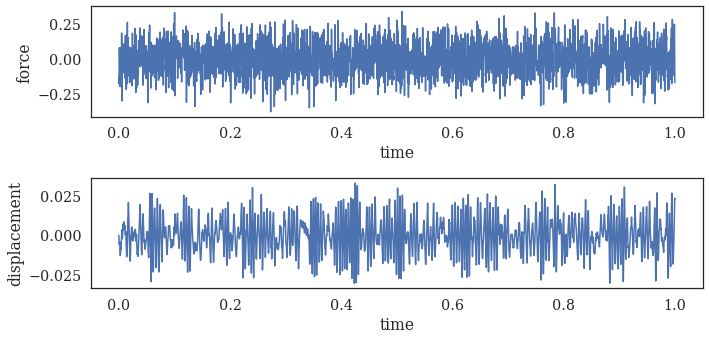

In [107]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('displacement')

plt.tight_layout()
plt.show()

5000


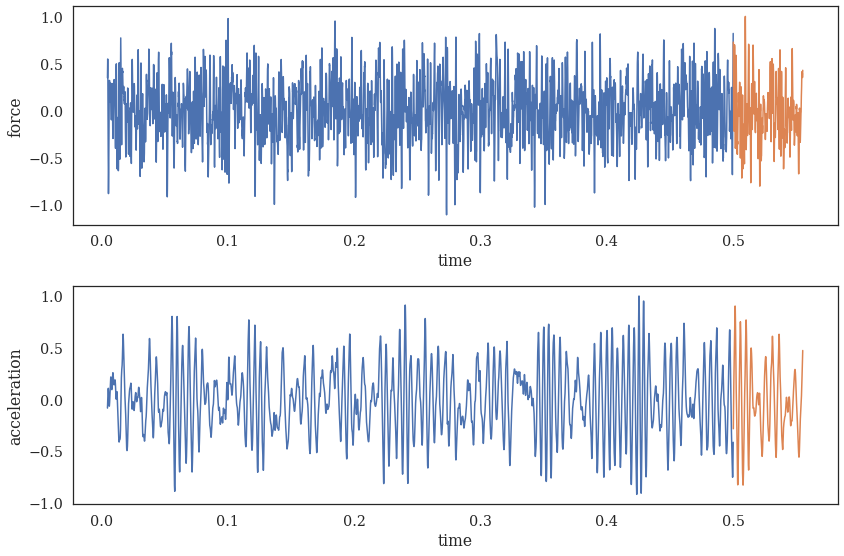

In [95]:
umax = np.max(u)
ymax = np.max(y)

u_norm = u/umax
y_norm = y/ymax

N = len(u)
ntrain = int(N*0.5)
start = 50

print(ntrain)
utrain = u_norm[start:ntrain]
ytrain = y_norm[start:ntrain]
ttrain = t[start:ntrain]
intrain = np.hstack([utrain,ytrain])

utest = u_norm[ntrain:start+ntrain+500]
ytest = y_norm[ntrain:start+ntrain+500]
ttest = t[ntrain:start+ntrain+500]
intest = np.hstack([utest,ytest])

ufull = np.concatenate([utrain, utest], axis = 0)
yfull = np.concatenate([ytrain, ytest], axis = 0)
infull = np.concatenate([intrain, intest], axis = 0)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(ttrain,utrain)
plt.plot(ttest,utest)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(ttrain,ytrain)
plt.plot(ttest,ytest)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

In [25]:
def create_inout_sequences(input_data, output_data, tw):
    xs = []
    ys = []

    for i in range(len(input_data)-tw-1):
        xy = input_data[i:(i+tw), 1]
        xu = input_data[i+1:(i+tw)+1, 0]
        x = np.vstack([xu,xy])
        y = output_data[i+tw]

        xs.append(x)
        ys.append(y)

    return np.transpose(np.array(xs),[0,1,2]), np.array(ys)

In [97]:
train_window = 24

x_train, y_train = create_inout_sequences(intrain, ytrain, train_window)
x_val, y_val = create_inout_sequences(intest, ytest, train_window)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

print(x_train.shape, y_train.shape)

x_full, y_full = create_inout_sequences(infull, yfull, train_window)

x_full = torch.from_numpy(x_full).float()
y_full = torch.from_numpy(y_full).float()

print(x_full.shape, y_full.shape)

torch.Size([4925, 2, 24]) torch.Size([4925, 1])
torch.Size([5475, 2, 24]) torch.Size([5475, 1])


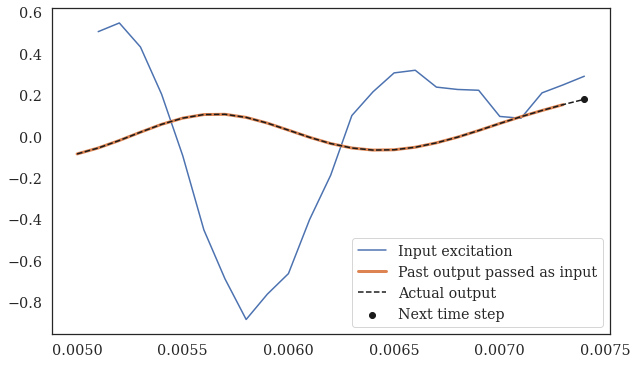

In [29]:
plt.figure(figsize=(10,6))
plt.plot(ttrain[1:train_window+1], x_train[0,0,:])
plt.plot(ttrain[:train_window], x_train[0,1,:], linewidth = 3)
plt.scatter(ttrain[train_window], y_train[0], color = 'k')
plt.plot(ttrain[:train_window + 1], ytrain[:train_window + 1], 'k--')
plt.legend(['Input excitation', 'Past output passed as input', 
           'Actual output', 'Next time step'], loc = 'best')
plt.show()

In [30]:
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [31]:
import torch.nn.functional as F


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, seq_len, dropout):
        super(TCN, self).__init__()
        self.seq_len = seq_len
        self.num_channels = num_channels
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1]*seq_len, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x).transpose(1, 2).reshape((-1, self.seq_len*self.num_channels[-1]))
        output = self.linear(output).double()
        return output

In [111]:
model = TCN(input_size = 2, 
            output_size = 1, 
            num_channels = [6]*6, 
            kernel_size = 3, 
            seq_len = train_window, 
            dropout = 0.1)

In [112]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction = "sum")

def train(model,epoch, X_train, Y_train, batch_size):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:, :, :], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size), :, :], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)

        loss = F.mse_loss(output, y.double())

        loss.backward()

        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 25 == 0:
            cur_loss = total_loss / 25
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate(model, X_test, Y_test):
    #model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()

In [113]:
epochs = 50000
batch_size = 250

for ep in range(1, epochs+1):
    train(model, ep, x_train, y_train, batch_size)
    print('Epoch: {}'.format(ep))
    tloss = evaluate(model, x_val, y_val)


Epoch: 1

Test set: Average loss: 0.123660

Epoch: 2

Test set: Average loss: 0.119245

Epoch: 3

Test set: Average loss: 0.117955

Epoch: 4

Test set: Average loss: 0.117966

Epoch: 5

Test set: Average loss: 0.116614

Epoch: 6

Test set: Average loss: 0.117452

Epoch: 7

Test set: Average loss: 0.116391

Epoch: 8

Test set: Average loss: 0.114752

Epoch: 9

Test set: Average loss: 0.113068

Epoch: 10

Test set: Average loss: 0.108851

Epoch: 11

Test set: Average loss: 0.107736

Epoch: 12

Test set: Average loss: 0.100956

Epoch: 13

Test set: Average loss: 0.102728

Epoch: 14

Test set: Average loss: 0.098728

Epoch: 15

Test set: Average loss: 0.095301

Epoch: 16

Test set: Average loss: 0.091446

Epoch: 17

Test set: Average loss: 0.087239

Epoch: 18

Test set: Average loss: 0.085216

Epoch: 19

Test set: Average loss: 0.078538

Epoch: 20

Test set: Average loss: 0.075417

Epoch: 21

Test set: Average loss: 0.070427

Epoch: 22

Test set: Average loss: 0.067781

Epoch: 23

Test set

Epoch: 182

Test set: Average loss: 0.005094

Epoch: 183

Test set: Average loss: 0.005618

Epoch: 184

Test set: Average loss: 0.005668

Epoch: 185

Test set: Average loss: 0.004892

Epoch: 186

Test set: Average loss: 0.004799

Epoch: 187

Test set: Average loss: 0.004984

Epoch: 188

Test set: Average loss: 0.005081

Epoch: 189

Test set: Average loss: 0.004530

Epoch: 190

Test set: Average loss: 0.004877

Epoch: 191

Test set: Average loss: 0.004444

Epoch: 192

Test set: Average loss: 0.004939

Epoch: 193

Test set: Average loss: 0.004642

Epoch: 194

Test set: Average loss: 0.004736

Epoch: 195

Test set: Average loss: 0.004394

Epoch: 196

Test set: Average loss: 0.004250

Epoch: 197

Test set: Average loss: 0.004073

Epoch: 198

Test set: Average loss: 0.004025

Epoch: 199

Test set: Average loss: 0.004422

Epoch: 200

Test set: Average loss: 0.004317

Epoch: 201

Test set: Average loss: 0.003998

Epoch: 202

Test set: Average loss: 0.004254

Epoch: 203

Test set: Average loss


Test set: Average loss: 0.001101

Epoch: 361

Test set: Average loss: 0.001243

Epoch: 362

Test set: Average loss: 0.001246

Epoch: 363

Test set: Average loss: 0.001026

Epoch: 364

Test set: Average loss: 0.001217

Epoch: 365

Test set: Average loss: 0.001143

Epoch: 366

Test set: Average loss: 0.001112

Epoch: 367

Test set: Average loss: 0.001161

Epoch: 368

Test set: Average loss: 0.001128

Epoch: 369

Test set: Average loss: 0.001185

Epoch: 370

Test set: Average loss: 0.001103

Epoch: 371

Test set: Average loss: 0.001029

Epoch: 372

Test set: Average loss: 0.001099

Epoch: 373

Test set: Average loss: 0.001117

Epoch: 374

Test set: Average loss: 0.001159

Epoch: 375

Test set: Average loss: 0.001051

Epoch: 376

Test set: Average loss: 0.001171

Epoch: 377

Test set: Average loss: 0.001164

Epoch: 378

Test set: Average loss: 0.001090

Epoch: 379

Test set: Average loss: 0.000990

Epoch: 380

Test set: Average loss: 0.001023

Epoch: 381

Test set: Average loss: 0.001060


Epoch: 539

Test set: Average loss: 0.000412

Epoch: 540

Test set: Average loss: 0.000380

Epoch: 541

Test set: Average loss: 0.000409

Epoch: 542

Test set: Average loss: 0.000387

Epoch: 543

Test set: Average loss: 0.000369

Epoch: 544

Test set: Average loss: 0.000362

Epoch: 545

Test set: Average loss: 0.000436

Epoch: 546

Test set: Average loss: 0.000384

Epoch: 547

Test set: Average loss: 0.000354

Epoch: 548

Test set: Average loss: 0.000392

Epoch: 549

Test set: Average loss: 0.000362

Epoch: 550

Test set: Average loss: 0.000392

Epoch: 551

Test set: Average loss: 0.000402

Epoch: 552

Test set: Average loss: 0.000384

Epoch: 553

Test set: Average loss: 0.000355

Epoch: 554

Test set: Average loss: 0.000373

Epoch: 555

Test set: Average loss: 0.000367

Epoch: 556

Test set: Average loss: 0.000349

Epoch: 557

Test set: Average loss: 0.000395

Epoch: 558

Test set: Average loss: 0.000349

Epoch: 559

Test set: Average loss: 0.000379

Epoch: 560

Test set: Average loss


Test set: Average loss: 0.000165

Epoch: 718

Test set: Average loss: 0.000183

Epoch: 719

Test set: Average loss: 0.000154

Epoch: 720

Test set: Average loss: 0.000154

Epoch: 721

Test set: Average loss: 0.000167

Epoch: 722

Test set: Average loss: 0.000181

Epoch: 723

Test set: Average loss: 0.000161

Epoch: 724

Test set: Average loss: 0.000156

Epoch: 725

Test set: Average loss: 0.000181

Epoch: 726

Test set: Average loss: 0.000164

Epoch: 727

Test set: Average loss: 0.000156

Epoch: 728

Test set: Average loss: 0.000154

Epoch: 729

Test set: Average loss: 0.000153

Epoch: 730

Test set: Average loss: 0.000152

Epoch: 731

Test set: Average loss: 0.000163

Epoch: 732

Test set: Average loss: 0.000174

Epoch: 733

Test set: Average loss: 0.000186

Epoch: 734

Test set: Average loss: 0.000170

Epoch: 735

Test set: Average loss: 0.000190

Epoch: 736

Test set: Average loss: 0.000136

Epoch: 737

Test set: Average loss: 0.000172

Epoch: 738

Test set: Average loss: 0.000151


Epoch: 896

Test set: Average loss: 0.000115

Epoch: 897

Test set: Average loss: 0.000103

Epoch: 898

Test set: Average loss: 0.000103

Epoch: 899

Test set: Average loss: 0.000104

Epoch: 900

Test set: Average loss: 0.000121

Epoch: 901

Test set: Average loss: 0.000106

Epoch: 902

Test set: Average loss: 0.000117

Epoch: 903

Test set: Average loss: 0.000110

Epoch: 904

Test set: Average loss: 0.000105

Epoch: 905

Test set: Average loss: 0.000105

Epoch: 906

Test set: Average loss: 0.000099

Epoch: 907

Test set: Average loss: 0.000117

Epoch: 908

Test set: Average loss: 0.000096

Epoch: 909

Test set: Average loss: 0.000118

Epoch: 910

Test set: Average loss: 0.000101

Epoch: 911

Test set: Average loss: 0.000115

Epoch: 912

Test set: Average loss: 0.000111

Epoch: 913

Test set: Average loss: 0.000106

Epoch: 914

Test set: Average loss: 0.000096

Epoch: 915

Test set: Average loss: 0.000093

Epoch: 916

Test set: Average loss: 0.000103

Epoch: 917

Test set: Average loss

Epoch: 1073

Test set: Average loss: 0.000091

Epoch: 1074

Test set: Average loss: 0.000079

Epoch: 1075

Test set: Average loss: 0.000078

Epoch: 1076

Test set: Average loss: 0.000082

Epoch: 1077

Test set: Average loss: 0.000085

Epoch: 1078

Test set: Average loss: 0.000087

Epoch: 1079

Test set: Average loss: 0.000077

Epoch: 1080

Test set: Average loss: 0.000077

Epoch: 1081

Test set: Average loss: 0.000076

Epoch: 1082

Test set: Average loss: 0.000081

Epoch: 1083

Test set: Average loss: 0.000098

Epoch: 1084

Test set: Average loss: 0.000080

Epoch: 1085

Test set: Average loss: 0.000078

Epoch: 1086

Test set: Average loss: 0.000078

Epoch: 1087

Test set: Average loss: 0.000072

Epoch: 1088

Test set: Average loss: 0.000076

Epoch: 1089

Test set: Average loss: 0.000075

Epoch: 1090

Test set: Average loss: 0.000071

Epoch: 1091

Test set: Average loss: 0.000077

Epoch: 1092

Test set: Average loss: 0.000079

Epoch: 1093

Test set: Average loss: 0.000082

Epoch: 1094



Epoch: 1248

Test set: Average loss: 0.000059

Epoch: 1249

Test set: Average loss: 0.000069

Epoch: 1250

Test set: Average loss: 0.000064

Epoch: 1251

Test set: Average loss: 0.000060

Epoch: 1252

Test set: Average loss: 0.000067

Epoch: 1253

Test set: Average loss: 0.000067

Epoch: 1254

Test set: Average loss: 0.000073

Epoch: 1255

Test set: Average loss: 0.000066

Epoch: 1256

Test set: Average loss: 0.000068

Epoch: 1257

Test set: Average loss: 0.000064

Epoch: 1258

Test set: Average loss: 0.000060

Epoch: 1259

Test set: Average loss: 0.000069

Epoch: 1260

Test set: Average loss: 0.000064

Epoch: 1261

Test set: Average loss: 0.000059

Epoch: 1262

Test set: Average loss: 0.000067

Epoch: 1263

Test set: Average loss: 0.000065

Epoch: 1264

Test set: Average loss: 0.000066

Epoch: 1265

Test set: Average loss: 0.000066

Epoch: 1266

Test set: Average loss: 0.000070

Epoch: 1267

Test set: Average loss: 0.000066

Epoch: 1268

Test set: Average loss: 0.000067

Epoch: 1269



Epoch: 1423

Test set: Average loss: 0.000059

Epoch: 1424

Test set: Average loss: 0.000055

Epoch: 1425

Test set: Average loss: 0.000049

Epoch: 1426

Test set: Average loss: 0.000060

Epoch: 1427

Test set: Average loss: 0.000055

Epoch: 1428

Test set: Average loss: 0.000057

Epoch: 1429

Test set: Average loss: 0.000054

Epoch: 1430

Test set: Average loss: 0.000059

Epoch: 1431

Test set: Average loss: 0.000059

Epoch: 1432

Test set: Average loss: 0.000063

Epoch: 1433

Test set: Average loss: 0.000055

Epoch: 1434

Test set: Average loss: 0.000053

Epoch: 1435

Test set: Average loss: 0.000054

Epoch: 1436

Test set: Average loss: 0.000050

Epoch: 1437

Test set: Average loss: 0.000057

Epoch: 1438

Test set: Average loss: 0.000053

Epoch: 1439

Test set: Average loss: 0.000055

Epoch: 1440

Test set: Average loss: 0.000058

Epoch: 1441

Test set: Average loss: 0.000059

Epoch: 1442

Test set: Average loss: 0.000061

Epoch: 1443

Test set: Average loss: 0.000057

Epoch: 1444



Epoch: 1598

Test set: Average loss: 0.000047

Epoch: 1599

Test set: Average loss: 0.000050

Epoch: 1600

Test set: Average loss: 0.000044

Epoch: 1601

Test set: Average loss: 0.000046

Epoch: 1602

Test set: Average loss: 0.000053

Epoch: 1603

Test set: Average loss: 0.000044

Epoch: 1604

Test set: Average loss: 0.000049

Epoch: 1605

Test set: Average loss: 0.000050

Epoch: 1606

Test set: Average loss: 0.000049

Epoch: 1607

Test set: Average loss: 0.000057

Epoch: 1608

Test set: Average loss: 0.000047

Epoch: 1609

Test set: Average loss: 0.000049

Epoch: 1610

Test set: Average loss: 0.000045

Epoch: 1611

Test set: Average loss: 0.000047

Epoch: 1612

Test set: Average loss: 0.000051

Epoch: 1613

Test set: Average loss: 0.000050

Epoch: 1614

Test set: Average loss: 0.000049

Epoch: 1615

Test set: Average loss: 0.000051

Epoch: 1616

Test set: Average loss: 0.000051

Epoch: 1617

Test set: Average loss: 0.000044

Epoch: 1618

Test set: Average loss: 0.000043

Epoch: 1619



Epoch: 1773

Test set: Average loss: 0.000044

Epoch: 1774

Test set: Average loss: 0.000044

Epoch: 1775

Test set: Average loss: 0.000043

Epoch: 1776

Test set: Average loss: 0.000049

Epoch: 1777

Test set: Average loss: 0.000047

Epoch: 1778

Test set: Average loss: 0.000041

Epoch: 1779

Test set: Average loss: 0.000042

Epoch: 1780

Test set: Average loss: 0.000046

Epoch: 1781

Test set: Average loss: 0.000043

Epoch: 1782

Test set: Average loss: 0.000041

Epoch: 1783

Test set: Average loss: 0.000047

Epoch: 1784

Test set: Average loss: 0.000048

Epoch: 1785

Test set: Average loss: 0.000046

Epoch: 1786

Test set: Average loss: 0.000051

Epoch: 1787

Test set: Average loss: 0.000044

Epoch: 1788

Test set: Average loss: 0.000046

Epoch: 1789

Test set: Average loss: 0.000057

Epoch: 1790

Test set: Average loss: 0.000044

Epoch: 1791

Test set: Average loss: 0.000045

Epoch: 1792

Test set: Average loss: 0.000044

Epoch: 1793

Test set: Average loss: 0.000044

Epoch: 1794



Epoch: 1948

Test set: Average loss: 0.000042

Epoch: 1949

Test set: Average loss: 0.000040

Epoch: 1950

Test set: Average loss: 0.000035

Epoch: 1951

Test set: Average loss: 0.000038

Epoch: 1952

Test set: Average loss: 0.000048

Epoch: 1953

Test set: Average loss: 0.000043

Epoch: 1954

Test set: Average loss: 0.000041

Epoch: 1955

Test set: Average loss: 0.000043

Epoch: 1956

Test set: Average loss: 0.000043

Epoch: 1957

Test set: Average loss: 0.000037

Epoch: 1958

Test set: Average loss: 0.000043

Epoch: 1959

Test set: Average loss: 0.000042

Epoch: 1960

Test set: Average loss: 0.000040

Epoch: 1961

Test set: Average loss: 0.000042

Epoch: 1962

Test set: Average loss: 0.000043

Epoch: 1963

Test set: Average loss: 0.000041

Epoch: 1964

Test set: Average loss: 0.000041

Epoch: 1965

Test set: Average loss: 0.000044

Epoch: 1966

Test set: Average loss: 0.000042

Epoch: 1967

Test set: Average loss: 0.000040

Epoch: 1968

Test set: Average loss: 0.000038

Epoch: 1969



Epoch: 2123

Test set: Average loss: 0.000036

Epoch: 2124

Test set: Average loss: 0.000038

Epoch: 2125

Test set: Average loss: 0.000038

Epoch: 2126

Test set: Average loss: 0.000039

Epoch: 2127

Test set: Average loss: 0.000037

Epoch: 2128

Test set: Average loss: 0.000039

Epoch: 2129

Test set: Average loss: 0.000039

Epoch: 2130

Test set: Average loss: 0.000036

Epoch: 2131

Test set: Average loss: 0.000041

Epoch: 2132

Test set: Average loss: 0.000042

Epoch: 2133

Test set: Average loss: 0.000039

Epoch: 2134

Test set: Average loss: 0.000041

Epoch: 2135

Test set: Average loss: 0.000042

Epoch: 2136

Test set: Average loss: 0.000042

Epoch: 2137

Test set: Average loss: 0.000038

Epoch: 2138

Test set: Average loss: 0.000038

Epoch: 2139

Test set: Average loss: 0.000039

Epoch: 2140

Test set: Average loss: 0.000038

Epoch: 2141

Test set: Average loss: 0.000034

Epoch: 2142

Test set: Average loss: 0.000037

Epoch: 2143

Test set: Average loss: 0.000039

Epoch: 2144



Epoch: 2298

Test set: Average loss: 0.000037

Epoch: 2299

Test set: Average loss: 0.000035

Epoch: 2300

Test set: Average loss: 0.000036

Epoch: 2301

Test set: Average loss: 0.000031

Epoch: 2302

Test set: Average loss: 0.000035

Epoch: 2303

Test set: Average loss: 0.000037

Epoch: 2304

Test set: Average loss: 0.000033

Epoch: 2305

Test set: Average loss: 0.000038

Epoch: 2306

Test set: Average loss: 0.000033

Epoch: 2307

Test set: Average loss: 0.000033

Epoch: 2308

Test set: Average loss: 0.000038

Epoch: 2309

Test set: Average loss: 0.000032

Epoch: 2310

Test set: Average loss: 0.000040

Epoch: 2311

Test set: Average loss: 0.000036

Epoch: 2312

Test set: Average loss: 0.000037

Epoch: 2313

Test set: Average loss: 0.000038

Epoch: 2314

Test set: Average loss: 0.000031

Epoch: 2315

Test set: Average loss: 0.000033

Epoch: 2316

Test set: Average loss: 0.000036

Epoch: 2317

Test set: Average loss: 0.000034

Epoch: 2318

Test set: Average loss: 0.000033

Epoch: 2319



Epoch: 2473

Test set: Average loss: 0.000032

Epoch: 2474

Test set: Average loss: 0.000037

Epoch: 2475

Test set: Average loss: 0.000035

Epoch: 2476

Test set: Average loss: 0.000038

Epoch: 2477

Test set: Average loss: 0.000033

Epoch: 2478

Test set: Average loss: 0.000033

Epoch: 2479

Test set: Average loss: 0.000033

Epoch: 2480

Test set: Average loss: 0.000030

Epoch: 2481

Test set: Average loss: 0.000031

Epoch: 2482

Test set: Average loss: 0.000036

Epoch: 2483

Test set: Average loss: 0.000030

Epoch: 2484

Test set: Average loss: 0.000034

Epoch: 2485

Test set: Average loss: 0.000034

Epoch: 2486

Test set: Average loss: 0.000033

Epoch: 2487

Test set: Average loss: 0.000037

Epoch: 2488

Test set: Average loss: 0.000034

Epoch: 2489

Test set: Average loss: 0.000031

Epoch: 2490

Test set: Average loss: 0.000035

Epoch: 2491

Test set: Average loss: 0.000030

Epoch: 2492

Test set: Average loss: 0.000036

Epoch: 2493

Test set: Average loss: 0.000032

Epoch: 2494



Epoch: 2648

Test set: Average loss: 0.000033

Epoch: 2649

Test set: Average loss: 0.000029

Epoch: 2650

Test set: Average loss: 0.000033

Epoch: 2651

Test set: Average loss: 0.000035

Epoch: 2652

Test set: Average loss: 0.000026

Epoch: 2653

Test set: Average loss: 0.000030

Epoch: 2654

Test set: Average loss: 0.000034

Epoch: 2655

Test set: Average loss: 0.000030

Epoch: 2656

Test set: Average loss: 0.000032

Epoch: 2657

Test set: Average loss: 0.000031

Epoch: 2658

Test set: Average loss: 0.000035

Epoch: 2659

Test set: Average loss: 0.000031

Epoch: 2660

Test set: Average loss: 0.000031

Epoch: 2661

Test set: Average loss: 0.000032

Epoch: 2662

Test set: Average loss: 0.000032

Epoch: 2663

Test set: Average loss: 0.000033

Epoch: 2664

Test set: Average loss: 0.000033

Epoch: 2665

Test set: Average loss: 0.000026

Epoch: 2666

Test set: Average loss: 0.000032

Epoch: 2667

Test set: Average loss: 0.000032

Epoch: 2668

Test set: Average loss: 0.000031

Epoch: 2669



Epoch: 2823

Test set: Average loss: 0.000029

Epoch: 2824

Test set: Average loss: 0.000027

Epoch: 2825

Test set: Average loss: 0.000029

Epoch: 2826

Test set: Average loss: 0.000031

Epoch: 2827

Test set: Average loss: 0.000030

Epoch: 2828

Test set: Average loss: 0.000028

Epoch: 2829

Test set: Average loss: 0.000031

Epoch: 2830

Test set: Average loss: 0.000030

Epoch: 2831

Test set: Average loss: 0.000029

Epoch: 2832

Test set: Average loss: 0.000029

Epoch: 2833

Test set: Average loss: 0.000030

Epoch: 2834

Test set: Average loss: 0.000032

Epoch: 2835

Test set: Average loss: 0.000031

Epoch: 2836

Test set: Average loss: 0.000031

Epoch: 2837

Test set: Average loss: 0.000030

Epoch: 2838

Test set: Average loss: 0.000032

Epoch: 2839

Test set: Average loss: 0.000028

Epoch: 2840

Test set: Average loss: 0.000031

Epoch: 2841

Test set: Average loss: 0.000029

Epoch: 2842

Test set: Average loss: 0.000033

Epoch: 2843

Test set: Average loss: 0.000029

Epoch: 2844



Epoch: 2998

Test set: Average loss: 0.000030

Epoch: 2999

Test set: Average loss: 0.000033

Epoch: 3000

Test set: Average loss: 0.000029

Epoch: 3001

Test set: Average loss: 0.000030

Epoch: 3002

Test set: Average loss: 0.000029

Epoch: 3003

Test set: Average loss: 0.000027

Epoch: 3004

Test set: Average loss: 0.000026

Epoch: 3005

Test set: Average loss: 0.000030

Epoch: 3006

Test set: Average loss: 0.000030

Epoch: 3007

Test set: Average loss: 0.000026

Epoch: 3008

Test set: Average loss: 0.000030

Epoch: 3009

Test set: Average loss: 0.000031

Epoch: 3010

Test set: Average loss: 0.000027

Epoch: 3011

Test set: Average loss: 0.000030

Epoch: 3012

Test set: Average loss: 0.000028

Epoch: 3013

Test set: Average loss: 0.000031

Epoch: 3014

Test set: Average loss: 0.000028

Epoch: 3015

Test set: Average loss: 0.000029

Epoch: 3016

Test set: Average loss: 0.000027

Epoch: 3017

Test set: Average loss: 0.000029

Epoch: 3018

Test set: Average loss: 0.000029

Epoch: 3019



Epoch: 3173

Test set: Average loss: 0.000028

Epoch: 3174

Test set: Average loss: 0.000028

Epoch: 3175

Test set: Average loss: 0.000027

Epoch: 3176

Test set: Average loss: 0.000028

Epoch: 3177

Test set: Average loss: 0.000028

Epoch: 3178

Test set: Average loss: 0.000027

Epoch: 3179

Test set: Average loss: 0.000027

Epoch: 3180

Test set: Average loss: 0.000027

Epoch: 3181

Test set: Average loss: 0.000029

Epoch: 3182

Test set: Average loss: 0.000025

Epoch: 3183

Test set: Average loss: 0.000025

Epoch: 3184

Test set: Average loss: 0.000027

Epoch: 3185

Test set: Average loss: 0.000025

Epoch: 3186

Test set: Average loss: 0.000024

Epoch: 3187

Test set: Average loss: 0.000029

Epoch: 3188

Test set: Average loss: 0.000026

Epoch: 3189

Test set: Average loss: 0.000026

Epoch: 3190

Test set: Average loss: 0.000029

Epoch: 3191

Test set: Average loss: 0.000027

Epoch: 3192

Test set: Average loss: 0.000026

Epoch: 3193

Test set: Average loss: 0.000029

Epoch: 3194



Epoch: 3348

Test set: Average loss: 0.000028

Epoch: 3349

Test set: Average loss: 0.000027

Epoch: 3350

Test set: Average loss: 0.000028

Epoch: 3351

Test set: Average loss: 0.000025

Epoch: 3352

Test set: Average loss: 0.000028

Epoch: 3353

Test set: Average loss: 0.000025

Epoch: 3354

Test set: Average loss: 0.000026

Epoch: 3355

Test set: Average loss: 0.000029

Epoch: 3356

Test set: Average loss: 0.000024

Epoch: 3357

Test set: Average loss: 0.000025

Epoch: 3358

Test set: Average loss: 0.000027

Epoch: 3359

Test set: Average loss: 0.000027

Epoch: 3360

Test set: Average loss: 0.000025

Epoch: 3361

Test set: Average loss: 0.000026

Epoch: 3362

Test set: Average loss: 0.000027

Epoch: 3363

Test set: Average loss: 0.000027

Epoch: 3364

Test set: Average loss: 0.000029

Epoch: 3365

Test set: Average loss: 0.000027

Epoch: 3366

Test set: Average loss: 0.000023

Epoch: 3367

Test set: Average loss: 0.000027

Epoch: 3368

Test set: Average loss: 0.000026

Epoch: 3369



Epoch: 3523

Test set: Average loss: 0.000028

Epoch: 3524

Test set: Average loss: 0.000025

Epoch: 3525

Test set: Average loss: 0.000025

Epoch: 3526

Test set: Average loss: 0.000026

Epoch: 3527

Test set: Average loss: 0.000025

Epoch: 3528

Test set: Average loss: 0.000027

Epoch: 3529

Test set: Average loss: 0.000024

Epoch: 3530

Test set: Average loss: 0.000024

Epoch: 3531

Test set: Average loss: 0.000028

Epoch: 3532

Test set: Average loss: 0.000028

Epoch: 3533

Test set: Average loss: 0.000025

Epoch: 3534

Test set: Average loss: 0.000021

Epoch: 3535

Test set: Average loss: 0.000025

Epoch: 3536

Test set: Average loss: 0.000028

Epoch: 3537

Test set: Average loss: 0.000027

Epoch: 3538

Test set: Average loss: 0.000024

Epoch: 3539

Test set: Average loss: 0.000026

Epoch: 3540

Test set: Average loss: 0.000024

Epoch: 3541

Test set: Average loss: 0.000025

Epoch: 3542

Test set: Average loss: 0.000029

Epoch: 3543

Test set: Average loss: 0.000025

Epoch: 3544



Epoch: 3698

Test set: Average loss: 0.000028

Epoch: 3699

Test set: Average loss: 0.000028

Epoch: 3700

Test set: Average loss: 0.000026

Epoch: 3701

Test set: Average loss: 0.000025

Epoch: 3702

Test set: Average loss: 0.000028

Epoch: 3703

Test set: Average loss: 0.000025

Epoch: 3704

Test set: Average loss: 0.000024

Epoch: 3705

Test set: Average loss: 0.000026

Epoch: 3706

Test set: Average loss: 0.000025

Epoch: 3707

Test set: Average loss: 0.000029

Epoch: 3708

Test set: Average loss: 0.000024

Epoch: 3709

Test set: Average loss: 0.000022

Epoch: 3710

Test set: Average loss: 0.000028

Epoch: 3711

Test set: Average loss: 0.000026

Epoch: 3712

Test set: Average loss: 0.000023

Epoch: 3713

Test set: Average loss: 0.000028

Epoch: 3714

Test set: Average loss: 0.000023

Epoch: 3715

Test set: Average loss: 0.000027

Epoch: 3716

Test set: Average loss: 0.000026

Epoch: 3717

Test set: Average loss: 0.000026

Epoch: 3718

Test set: Average loss: 0.000026

Epoch: 3719



Epoch: 3873

Test set: Average loss: 0.000020

Epoch: 3874

Test set: Average loss: 0.000025

Epoch: 3875

Test set: Average loss: 0.000028

Epoch: 3876

Test set: Average loss: 0.000025

Epoch: 3877

Test set: Average loss: 0.000025

Epoch: 3878

Test set: Average loss: 0.000026

Epoch: 3879

Test set: Average loss: 0.000027

Epoch: 3880

Test set: Average loss: 0.000024

Epoch: 3881

Test set: Average loss: 0.000023

Epoch: 3882

Test set: Average loss: 0.000024

Epoch: 3883

Test set: Average loss: 0.000029

Epoch: 3884

Test set: Average loss: 0.000031

Epoch: 3885

Test set: Average loss: 0.000024

Epoch: 3886

Test set: Average loss: 0.000024

Epoch: 3887

Test set: Average loss: 0.000023

Epoch: 3888

Test set: Average loss: 0.000024

Epoch: 3889

Test set: Average loss: 0.000026

Epoch: 3890

Test set: Average loss: 0.000022

Epoch: 3891

Test set: Average loss: 0.000024

Epoch: 3892

Test set: Average loss: 0.000023

Epoch: 3893

Test set: Average loss: 0.000029

Epoch: 3894



Epoch: 4048

Test set: Average loss: 0.000024

Epoch: 4049

Test set: Average loss: 0.000026

Epoch: 4050

Test set: Average loss: 0.000025

Epoch: 4051

Test set: Average loss: 0.000021

Epoch: 4052

Test set: Average loss: 0.000025

Epoch: 4053

Test set: Average loss: 0.000023

Epoch: 4054

Test set: Average loss: 0.000025

Epoch: 4055

Test set: Average loss: 0.000024

Epoch: 4056

Test set: Average loss: 0.000024

Epoch: 4057

Test set: Average loss: 0.000026

Epoch: 4058

Test set: Average loss: 0.000022

Epoch: 4059

Test set: Average loss: 0.000021

Epoch: 4060

Test set: Average loss: 0.000025

Epoch: 4061

Test set: Average loss: 0.000023

Epoch: 4062

Test set: Average loss: 0.000024

Epoch: 4063

Test set: Average loss: 0.000021

Epoch: 4064

Test set: Average loss: 0.000023

Epoch: 4065

Test set: Average loss: 0.000026

Epoch: 4066

Test set: Average loss: 0.000027

Epoch: 4067

Test set: Average loss: 0.000021

Epoch: 4068

Test set: Average loss: 0.000022

Epoch: 4069



Epoch: 4223

Test set: Average loss: 0.000026

Epoch: 4224

Test set: Average loss: 0.000019

Epoch: 4225

Test set: Average loss: 0.000022

Epoch: 4226

Test set: Average loss: 0.000024

Epoch: 4227

Test set: Average loss: 0.000024

Epoch: 4228

Test set: Average loss: 0.000022

Epoch: 4229

Test set: Average loss: 0.000023

Epoch: 4230

Test set: Average loss: 0.000022

Epoch: 4231

Test set: Average loss: 0.000026

Epoch: 4232

Test set: Average loss: 0.000025

Epoch: 4233

Test set: Average loss: 0.000020

Epoch: 4234

Test set: Average loss: 0.000022

Epoch: 4235

Test set: Average loss: 0.000022

Epoch: 4236

Test set: Average loss: 0.000026

Epoch: 4237

Test set: Average loss: 0.000024

Epoch: 4238

Test set: Average loss: 0.000023

Epoch: 4239

Test set: Average loss: 0.000022

Epoch: 4240

Test set: Average loss: 0.000023

Epoch: 4241

Test set: Average loss: 0.000024

Epoch: 4242

Test set: Average loss: 0.000021

Epoch: 4243

Test set: Average loss: 0.000023

Epoch: 4244



Epoch: 4398

Test set: Average loss: 0.000023

Epoch: 4399

Test set: Average loss: 0.000022

Epoch: 4400

Test set: Average loss: 0.000024

Epoch: 4401

Test set: Average loss: 0.000019

Epoch: 4402

Test set: Average loss: 0.000022

Epoch: 4403

Test set: Average loss: 0.000022

Epoch: 4404

Test set: Average loss: 0.000023

Epoch: 4405

Test set: Average loss: 0.000022

Epoch: 4406

Test set: Average loss: 0.000023

Epoch: 4407

Test set: Average loss: 0.000021

Epoch: 4408

Test set: Average loss: 0.000021

Epoch: 4409

Test set: Average loss: 0.000024

Epoch: 4410

Test set: Average loss: 0.000023

Epoch: 4411

Test set: Average loss: 0.000024

Epoch: 4412

Test set: Average loss: 0.000023

Epoch: 4413

Test set: Average loss: 0.000021

Epoch: 4414

Test set: Average loss: 0.000023

Epoch: 4415

Test set: Average loss: 0.000022

Epoch: 4416

Test set: Average loss: 0.000023

Epoch: 4417

Test set: Average loss: 0.000023

Epoch: 4418

Test set: Average loss: 0.000021

Epoch: 4419



Epoch: 4573

Test set: Average loss: 0.000018

Epoch: 4574

Test set: Average loss: 0.000021

Epoch: 4575

Test set: Average loss: 0.000022

Epoch: 4576

Test set: Average loss: 0.000020

Epoch: 4577

Test set: Average loss: 0.000021

Epoch: 4578

Test set: Average loss: 0.000018

Epoch: 4579

Test set: Average loss: 0.000023

Epoch: 4580

Test set: Average loss: 0.000022

Epoch: 4581

Test set: Average loss: 0.000022

Epoch: 4582

Test set: Average loss: 0.000022

Epoch: 4583

Test set: Average loss: 0.000023

Epoch: 4584

Test set: Average loss: 0.000025

Epoch: 4585

Test set: Average loss: 0.000023

Epoch: 4586

Test set: Average loss: 0.000024

Epoch: 4587

Test set: Average loss: 0.000023

Epoch: 4588

Test set: Average loss: 0.000021

Epoch: 4589

Test set: Average loss: 0.000020

Epoch: 4590

Test set: Average loss: 0.000019

Epoch: 4591

Test set: Average loss: 0.000021

Epoch: 4592

Test set: Average loss: 0.000020

Epoch: 4593

Test set: Average loss: 0.000021

Epoch: 4594



Epoch: 4748

Test set: Average loss: 0.000020

Epoch: 4749

Test set: Average loss: 0.000018

Epoch: 4750

Test set: Average loss: 0.000021

Epoch: 4751

Test set: Average loss: 0.000021

Epoch: 4752

Test set: Average loss: 0.000021

Epoch: 4753

Test set: Average loss: 0.000020

Epoch: 4754

Test set: Average loss: 0.000019

Epoch: 4755

Test set: Average loss: 0.000022

Epoch: 4756

Test set: Average loss: 0.000022

Epoch: 4757

Test set: Average loss: 0.000021

Epoch: 4758

Test set: Average loss: 0.000021

Epoch: 4759

Test set: Average loss: 0.000021

Epoch: 4760

Test set: Average loss: 0.000021

Epoch: 4761

Test set: Average loss: 0.000021

Epoch: 4762

Test set: Average loss: 0.000019

Epoch: 4763

Test set: Average loss: 0.000025

Epoch: 4764

Test set: Average loss: 0.000023

Epoch: 4765

Test set: Average loss: 0.000021

Epoch: 4766

Test set: Average loss: 0.000019

Epoch: 4767

Test set: Average loss: 0.000021

Epoch: 4768

Test set: Average loss: 0.000021

Epoch: 4769



Epoch: 4923

Test set: Average loss: 0.000019

Epoch: 4924

Test set: Average loss: 0.000019

Epoch: 4925

Test set: Average loss: 0.000020

Epoch: 4926

Test set: Average loss: 0.000022

Epoch: 4927

Test set: Average loss: 0.000024

Epoch: 4928

Test set: Average loss: 0.000020

Epoch: 4929

Test set: Average loss: 0.000022

Epoch: 4930

Test set: Average loss: 0.000020

Epoch: 4931

Test set: Average loss: 0.000020

Epoch: 4932

Test set: Average loss: 0.000020

Epoch: 4933

Test set: Average loss: 0.000020

Epoch: 4934

Test set: Average loss: 0.000020

Epoch: 4935

Test set: Average loss: 0.000019

Epoch: 4936

Test set: Average loss: 0.000021

Epoch: 4937

Test set: Average loss: 0.000020

Epoch: 4938

Test set: Average loss: 0.000020

Epoch: 4939

Test set: Average loss: 0.000020

Epoch: 4940

Test set: Average loss: 0.000019

Epoch: 4941

Test set: Average loss: 0.000020

Epoch: 4942

Test set: Average loss: 0.000017

Epoch: 4943

Test set: Average loss: 0.000019

Epoch: 4944



Epoch: 5098

Test set: Average loss: 0.000020

Epoch: 5099

Test set: Average loss: 0.000020

Epoch: 5100

Test set: Average loss: 0.000020

Epoch: 5101

Test set: Average loss: 0.000020

Epoch: 5102

Test set: Average loss: 0.000019

Epoch: 5103

Test set: Average loss: 0.000020

Epoch: 5104

Test set: Average loss: 0.000021

Epoch: 5105

Test set: Average loss: 0.000018

Epoch: 5106

Test set: Average loss: 0.000019

Epoch: 5107

Test set: Average loss: 0.000021

Epoch: 5108

Test set: Average loss: 0.000021

Epoch: 5109

Test set: Average loss: 0.000017

Epoch: 5110

Test set: Average loss: 0.000020

Epoch: 5111

Test set: Average loss: 0.000020

Epoch: 5112

Test set: Average loss: 0.000020

Epoch: 5113

Test set: Average loss: 0.000022

Epoch: 5114

Test set: Average loss: 0.000019

Epoch: 5115

Test set: Average loss: 0.000022

Epoch: 5116

Test set: Average loss: 0.000022

Epoch: 5117

Test set: Average loss: 0.000022

Epoch: 5118

Test set: Average loss: 0.000018

Epoch: 5119



Epoch: 5273

Test set: Average loss: 0.000021

Epoch: 5274

Test set: Average loss: 0.000017

Epoch: 5275

Test set: Average loss: 0.000025

Epoch: 5276

Test set: Average loss: 0.000018

Epoch: 5277

Test set: Average loss: 0.000020

Epoch: 5278

Test set: Average loss: 0.000021

Epoch: 5279

Test set: Average loss: 0.000021

Epoch: 5280

Test set: Average loss: 0.000020

Epoch: 5281

Test set: Average loss: 0.000019

Epoch: 5282

Test set: Average loss: 0.000018

Epoch: 5283

Test set: Average loss: 0.000019

Epoch: 5284

Test set: Average loss: 0.000017

Epoch: 5285

Test set: Average loss: 0.000018

Epoch: 5286

Test set: Average loss: 0.000020

Epoch: 5287

Test set: Average loss: 0.000017

Epoch: 5288

Test set: Average loss: 0.000019

Epoch: 5289

Test set: Average loss: 0.000018

Epoch: 5290

Test set: Average loss: 0.000017

Epoch: 5291

Test set: Average loss: 0.000020

Epoch: 5292

Test set: Average loss: 0.000021

Epoch: 5293

Test set: Average loss: 0.000021

Epoch: 5294



Epoch: 5448

Test set: Average loss: 0.000017

Epoch: 5449

Test set: Average loss: 0.000016

Epoch: 5450

Test set: Average loss: 0.000019

Epoch: 5451

Test set: Average loss: 0.000021

Epoch: 5452

Test set: Average loss: 0.000019

Epoch: 5453

Test set: Average loss: 0.000019

Epoch: 5454

Test set: Average loss: 0.000021

Epoch: 5455

Test set: Average loss: 0.000019

Epoch: 5456

Test set: Average loss: 0.000021

Epoch: 5457

Test set: Average loss: 0.000017

Epoch: 5458

Test set: Average loss: 0.000019

Epoch: 5459

Test set: Average loss: 0.000022

Epoch: 5460

Test set: Average loss: 0.000021

Epoch: 5461

Test set: Average loss: 0.000021

Epoch: 5462

Test set: Average loss: 0.000018

Epoch: 5463

Test set: Average loss: 0.000017

Epoch: 5464

Test set: Average loss: 0.000017

Epoch: 5465

Test set: Average loss: 0.000022

Epoch: 5466

Test set: Average loss: 0.000018

Epoch: 5467

Test set: Average loss: 0.000019

Epoch: 5468

Test set: Average loss: 0.000022

Epoch: 5469



Epoch: 5623

Test set: Average loss: 0.000018

Epoch: 5624

Test set: Average loss: 0.000020

Epoch: 5625

Test set: Average loss: 0.000020

Epoch: 5626

Test set: Average loss: 0.000018

Epoch: 5627

Test set: Average loss: 0.000020

Epoch: 5628

Test set: Average loss: 0.000017

Epoch: 5629

Test set: Average loss: 0.000019

Epoch: 5630

Test set: Average loss: 0.000017

Epoch: 5631

Test set: Average loss: 0.000020

Epoch: 5632

Test set: Average loss: 0.000020

Epoch: 5633

Test set: Average loss: 0.000019

Epoch: 5634

Test set: Average loss: 0.000021

Epoch: 5635

Test set: Average loss: 0.000019

Epoch: 5636

Test set: Average loss: 0.000019

Epoch: 5637

Test set: Average loss: 0.000019

Epoch: 5638

Test set: Average loss: 0.000019

Epoch: 5639

Test set: Average loss: 0.000019

Epoch: 5640

Test set: Average loss: 0.000018

Epoch: 5641

Test set: Average loss: 0.000018

Epoch: 5642

Test set: Average loss: 0.000019

Epoch: 5643

Test set: Average loss: 0.000019

Epoch: 5644



Epoch: 5798

Test set: Average loss: 0.000016

Epoch: 5799

Test set: Average loss: 0.000020

Epoch: 5800

Test set: Average loss: 0.000018

Epoch: 5801

Test set: Average loss: 0.000019

Epoch: 5802

Test set: Average loss: 0.000020

Epoch: 5803

Test set: Average loss: 0.000020

Epoch: 5804

Test set: Average loss: 0.000017

Epoch: 5805

Test set: Average loss: 0.000015

Epoch: 5806

Test set: Average loss: 0.000017

Epoch: 5807

Test set: Average loss: 0.000017

Epoch: 5808

Test set: Average loss: 0.000018

Epoch: 5809

Test set: Average loss: 0.000017

Epoch: 5810

Test set: Average loss: 0.000016

Epoch: 5811

Test set: Average loss: 0.000019

Epoch: 5812

Test set: Average loss: 0.000017

Epoch: 5813

Test set: Average loss: 0.000018

Epoch: 5814

Test set: Average loss: 0.000019

Epoch: 5815

Test set: Average loss: 0.000018

Epoch: 5816

Test set: Average loss: 0.000019

Epoch: 5817

Test set: Average loss: 0.000016

Epoch: 5818

Test set: Average loss: 0.000018

Epoch: 5819



Epoch: 5973

Test set: Average loss: 0.000018

Epoch: 5974

Test set: Average loss: 0.000018

Epoch: 5975

Test set: Average loss: 0.000015

Epoch: 5976

Test set: Average loss: 0.000021

Epoch: 5977

Test set: Average loss: 0.000019

Epoch: 5978

Test set: Average loss: 0.000015

Epoch: 5979

Test set: Average loss: 0.000017

Epoch: 5980

Test set: Average loss: 0.000018

Epoch: 5981

Test set: Average loss: 0.000021

Epoch: 5982

Test set: Average loss: 0.000017

Epoch: 5983

Test set: Average loss: 0.000017

Epoch: 5984

Test set: Average loss: 0.000017

Epoch: 5985

Test set: Average loss: 0.000017

Epoch: 5986

Test set: Average loss: 0.000017

Epoch: 5987

Test set: Average loss: 0.000018

Epoch: 5988

Test set: Average loss: 0.000017

Epoch: 5989

Test set: Average loss: 0.000015

Epoch: 5990

Test set: Average loss: 0.000017

Epoch: 5991

Test set: Average loss: 0.000017

Epoch: 5992

Test set: Average loss: 0.000018

Epoch: 5993

Test set: Average loss: 0.000016

Epoch: 5994



Epoch: 6148

Test set: Average loss: 0.000016

Epoch: 6149

Test set: Average loss: 0.000017

Epoch: 6150

Test set: Average loss: 0.000017

Epoch: 6151

Test set: Average loss: 0.000017

Epoch: 6152

Test set: Average loss: 0.000016

Epoch: 6153

Test set: Average loss: 0.000020

Epoch: 6154

Test set: Average loss: 0.000018

Epoch: 6155

Test set: Average loss: 0.000018

Epoch: 6156

Test set: Average loss: 0.000019

Epoch: 6157

Test set: Average loss: 0.000017

Epoch: 6158

Test set: Average loss: 0.000018

Epoch: 6159

Test set: Average loss: 0.000019

Epoch: 6160

Test set: Average loss: 0.000018

Epoch: 6161

Test set: Average loss: 0.000020

Epoch: 6162

Test set: Average loss: 0.000016

Epoch: 6163

Test set: Average loss: 0.000016

Epoch: 6164

Test set: Average loss: 0.000018

Epoch: 6165

Test set: Average loss: 0.000017

Epoch: 6166

Test set: Average loss: 0.000016

Epoch: 6167

Test set: Average loss: 0.000020

Epoch: 6168

Test set: Average loss: 0.000015

Epoch: 6169



Epoch: 6323

Test set: Average loss: 0.000017

Epoch: 6324

Test set: Average loss: 0.000017

Epoch: 6325

Test set: Average loss: 0.000015

Epoch: 6326

Test set: Average loss: 0.000016

Epoch: 6327

Test set: Average loss: 0.000016

Epoch: 6328

Test set: Average loss: 0.000015

Epoch: 6329

Test set: Average loss: 0.000017

Epoch: 6330

Test set: Average loss: 0.000017

Epoch: 6331

Test set: Average loss: 0.000017

Epoch: 6332

Test set: Average loss: 0.000017

Epoch: 6333

Test set: Average loss: 0.000017

Epoch: 6334

Test set: Average loss: 0.000015

Epoch: 6335

Test set: Average loss: 0.000016

Epoch: 6336

Test set: Average loss: 0.000017

Epoch: 6337

Test set: Average loss: 0.000016

Epoch: 6338

Test set: Average loss: 0.000017

Epoch: 6339

Test set: Average loss: 0.000018

Epoch: 6340

Test set: Average loss: 0.000017

Epoch: 6341

Test set: Average loss: 0.000015

Epoch: 6342

Test set: Average loss: 0.000017

Epoch: 6343

Test set: Average loss: 0.000017

Epoch: 6344



Epoch: 6498

Test set: Average loss: 0.000015

Epoch: 6499

Test set: Average loss: 0.000017

Epoch: 6500

Test set: Average loss: 0.000020

Epoch: 6501

Test set: Average loss: 0.000015

Epoch: 6502

Test set: Average loss: 0.000018

Epoch: 6503

Test set: Average loss: 0.000017

Epoch: 6504

Test set: Average loss: 0.000019

Epoch: 6505

Test set: Average loss: 0.000019

Epoch: 6506

Test set: Average loss: 0.000022

Epoch: 6507

Test set: Average loss: 0.000017

Epoch: 6508

Test set: Average loss: 0.000022

Epoch: 6509

Test set: Average loss: 0.000016

Epoch: 6510

Test set: Average loss: 0.000017

Epoch: 6511

Test set: Average loss: 0.000018

Epoch: 6512

Test set: Average loss: 0.000017

Epoch: 6513

Test set: Average loss: 0.000018

Epoch: 6514

Test set: Average loss: 0.000015

Epoch: 6515

Test set: Average loss: 0.000013

Epoch: 6516

Test set: Average loss: 0.000016

Epoch: 6517

Test set: Average loss: 0.000015

Epoch: 6518

Test set: Average loss: 0.000016

Epoch: 6519



Epoch: 6673

Test set: Average loss: 0.000016

Epoch: 6674

Test set: Average loss: 0.000017

Epoch: 6675

Test set: Average loss: 0.000015

Epoch: 6676

Test set: Average loss: 0.000015

Epoch: 6677

Test set: Average loss: 0.000016

Epoch: 6678

Test set: Average loss: 0.000018

Epoch: 6679

Test set: Average loss: 0.000019

Epoch: 6680

Test set: Average loss: 0.000014

Epoch: 6681

Test set: Average loss: 0.000018

Epoch: 6682

Test set: Average loss: 0.000019

Epoch: 6683

Test set: Average loss: 0.000016

Epoch: 6684

Test set: Average loss: 0.000015

Epoch: 6685

Test set: Average loss: 0.000017

Epoch: 6686

Test set: Average loss: 0.000015

Epoch: 6687

Test set: Average loss: 0.000017

Epoch: 6688

Test set: Average loss: 0.000015

Epoch: 6689

Test set: Average loss: 0.000017

Epoch: 6690

Test set: Average loss: 0.000015

Epoch: 6691

Test set: Average loss: 0.000016

Epoch: 6692

Test set: Average loss: 0.000016

Epoch: 6693

Test set: Average loss: 0.000018

Epoch: 6694



Epoch: 6848

Test set: Average loss: 0.000016

Epoch: 6849

Test set: Average loss: 0.000015

Epoch: 6850

Test set: Average loss: 0.000019

Epoch: 6851

Test set: Average loss: 0.000014

Epoch: 6852

Test set: Average loss: 0.000018

Epoch: 6853

Test set: Average loss: 0.000017

Epoch: 6854

Test set: Average loss: 0.000017

Epoch: 6855

Test set: Average loss: 0.000013

Epoch: 6856

Test set: Average loss: 0.000016

Epoch: 6857

Test set: Average loss: 0.000018

Epoch: 6858

Test set: Average loss: 0.000016

Epoch: 6859

Test set: Average loss: 0.000017

Epoch: 6860

Test set: Average loss: 0.000018

Epoch: 6861

Test set: Average loss: 0.000017

Epoch: 6862

Test set: Average loss: 0.000015

Epoch: 6863

Test set: Average loss: 0.000016

Epoch: 6864

Test set: Average loss: 0.000016

Epoch: 6865

Test set: Average loss: 0.000015

Epoch: 6866

Test set: Average loss: 0.000016

Epoch: 6867

Test set: Average loss: 0.000016

Epoch: 6868

Test set: Average loss: 0.000016

Epoch: 6869



Epoch: 7023

Test set: Average loss: 0.000016

Epoch: 7024

Test set: Average loss: 0.000014

Epoch: 7025

Test set: Average loss: 0.000016

Epoch: 7026

Test set: Average loss: 0.000015

Epoch: 7027

Test set: Average loss: 0.000016

Epoch: 7028

Test set: Average loss: 0.000016

Epoch: 7029

Test set: Average loss: 0.000015

Epoch: 7030

Test set: Average loss: 0.000017

Epoch: 7031

Test set: Average loss: 0.000015

Epoch: 7032

Test set: Average loss: 0.000017

Epoch: 7033

Test set: Average loss: 0.000014

Epoch: 7034

Test set: Average loss: 0.000016

Epoch: 7035

Test set: Average loss: 0.000017

Epoch: 7036

Test set: Average loss: 0.000019

Epoch: 7037

Test set: Average loss: 0.000019

Epoch: 7038

Test set: Average loss: 0.000016

Epoch: 7039

Test set: Average loss: 0.000014

Epoch: 7040

Test set: Average loss: 0.000015

Epoch: 7041

Test set: Average loss: 0.000015

Epoch: 7042

Test set: Average loss: 0.000016

Epoch: 7043

Test set: Average loss: 0.000018

Epoch: 7044



Epoch: 7198

Test set: Average loss: 0.000017

Epoch: 7199

Test set: Average loss: 0.000016

Epoch: 7200

Test set: Average loss: 0.000015

Epoch: 7201

Test set: Average loss: 0.000017

Epoch: 7202

Test set: Average loss: 0.000017

Epoch: 7203

Test set: Average loss: 0.000016

Epoch: 7204

Test set: Average loss: 0.000016

Epoch: 7205

Test set: Average loss: 0.000014

Epoch: 7206

Test set: Average loss: 0.000016

Epoch: 7207

Test set: Average loss: 0.000016

Epoch: 7208

Test set: Average loss: 0.000015

Epoch: 7209

Test set: Average loss: 0.000017

Epoch: 7210

Test set: Average loss: 0.000015

Epoch: 7211

Test set: Average loss: 0.000014

Epoch: 7212

Test set: Average loss: 0.000016

Epoch: 7213

Test set: Average loss: 0.000017

Epoch: 7214

Test set: Average loss: 0.000016

Epoch: 7215

Test set: Average loss: 0.000017

Epoch: 7216

Test set: Average loss: 0.000014

Epoch: 7217

Test set: Average loss: 0.000018

Epoch: 7218

Test set: Average loss: 0.000016

Epoch: 7219



Epoch: 7373

Test set: Average loss: 0.000016

Epoch: 7374

Test set: Average loss: 0.000016

Epoch: 7375

Test set: Average loss: 0.000014

Epoch: 7376

Test set: Average loss: 0.000013

Epoch: 7377

Test set: Average loss: 0.000015

Epoch: 7378

Test set: Average loss: 0.000019

Epoch: 7379

Test set: Average loss: 0.000016

Epoch: 7380

Test set: Average loss: 0.000016

Epoch: 7381

Test set: Average loss: 0.000015

Epoch: 7382

Test set: Average loss: 0.000015

Epoch: 7383

Test set: Average loss: 0.000015

Epoch: 7384

Test set: Average loss: 0.000017

Epoch: 7385

Test set: Average loss: 0.000015

Epoch: 7386

Test set: Average loss: 0.000017

Epoch: 7387

Test set: Average loss: 0.000020

Epoch: 7388

Test set: Average loss: 0.000017

Epoch: 7389

Test set: Average loss: 0.000016

Epoch: 7390

Test set: Average loss: 0.000015

Epoch: 7391

Test set: Average loss: 0.000015

Epoch: 7392

Test set: Average loss: 0.000016

Epoch: 7393

Test set: Average loss: 0.000017

Epoch: 7394



Epoch: 7548

Test set: Average loss: 0.000015

Epoch: 7549

Test set: Average loss: 0.000018

Epoch: 7550

Test set: Average loss: 0.000016

Epoch: 7551

Test set: Average loss: 0.000015

Epoch: 7552

Test set: Average loss: 0.000016

Epoch: 7553

Test set: Average loss: 0.000016

Epoch: 7554

Test set: Average loss: 0.000016

Epoch: 7555

Test set: Average loss: 0.000016

Epoch: 7556

Test set: Average loss: 0.000015

Epoch: 7557

Test set: Average loss: 0.000015

Epoch: 7558

Test set: Average loss: 0.000014

Epoch: 7559

Test set: Average loss: 0.000015

Epoch: 7560

Test set: Average loss: 0.000015

Epoch: 7561

Test set: Average loss: 0.000016

Epoch: 7562

Test set: Average loss: 0.000015

Epoch: 7563

Test set: Average loss: 0.000015

Epoch: 7564

Test set: Average loss: 0.000017

Epoch: 7565

Test set: Average loss: 0.000017

Epoch: 7566

Test set: Average loss: 0.000013

Epoch: 7567

Test set: Average loss: 0.000015

Epoch: 7568

Test set: Average loss: 0.000016

Epoch: 7569



Epoch: 7723

Test set: Average loss: 0.000014

Epoch: 7724

Test set: Average loss: 0.000014

Epoch: 7725

Test set: Average loss: 0.000014

Epoch: 7726

Test set: Average loss: 0.000016

Epoch: 7727

Test set: Average loss: 0.000015

Epoch: 7728

Test set: Average loss: 0.000015

Epoch: 7729

Test set: Average loss: 0.000014

Epoch: 7730

Test set: Average loss: 0.000017

Epoch: 7731

Test set: Average loss: 0.000017

Epoch: 7732

Test set: Average loss: 0.000016

Epoch: 7733

Test set: Average loss: 0.000016

Epoch: 7734

Test set: Average loss: 0.000014

Epoch: 7735

Test set: Average loss: 0.000014

Epoch: 7736

Test set: Average loss: 0.000014

Epoch: 7737

Test set: Average loss: 0.000014

Epoch: 7738

Test set: Average loss: 0.000014

Epoch: 7739

Test set: Average loss: 0.000014

Epoch: 7740

Test set: Average loss: 0.000015

Epoch: 7741

Test set: Average loss: 0.000014

Epoch: 7742

Test set: Average loss: 0.000015

Epoch: 7743

Test set: Average loss: 0.000014

Epoch: 7744



Epoch: 7898

Test set: Average loss: 0.000015

Epoch: 7899

Test set: Average loss: 0.000014

Epoch: 7900

Test set: Average loss: 0.000015

Epoch: 7901

Test set: Average loss: 0.000015

Epoch: 7902

Test set: Average loss: 0.000014

Epoch: 7903

Test set: Average loss: 0.000013

Epoch: 7904

Test set: Average loss: 0.000014

Epoch: 7905

Test set: Average loss: 0.000014

Epoch: 7906

Test set: Average loss: 0.000015

Epoch: 7907

Test set: Average loss: 0.000016

Epoch: 7908

Test set: Average loss: 0.000016

Epoch: 7909

Test set: Average loss: 0.000014

Epoch: 7910

Test set: Average loss: 0.000013

Epoch: 7911

Test set: Average loss: 0.000015

Epoch: 7912

Test set: Average loss: 0.000016

Epoch: 7913

Test set: Average loss: 0.000014

Epoch: 7914

Test set: Average loss: 0.000013

Epoch: 7915

Test set: Average loss: 0.000012

Epoch: 7916

Test set: Average loss: 0.000015

Epoch: 7917

Test set: Average loss: 0.000014

Epoch: 7918

Test set: Average loss: 0.000014

Epoch: 7919



Epoch: 8073

Test set: Average loss: 0.000015

Epoch: 8074

Test set: Average loss: 0.000014

Epoch: 8075

Test set: Average loss: 0.000013

Epoch: 8076

Test set: Average loss: 0.000016

Epoch: 8077

Test set: Average loss: 0.000013

Epoch: 8078

Test set: Average loss: 0.000014

Epoch: 8079

Test set: Average loss: 0.000013

Epoch: 8080

Test set: Average loss: 0.000017

Epoch: 8081

Test set: Average loss: 0.000015

Epoch: 8082

Test set: Average loss: 0.000014

Epoch: 8083

Test set: Average loss: 0.000013

Epoch: 8084

Test set: Average loss: 0.000013

Epoch: 8085

Test set: Average loss: 0.000015

Epoch: 8086

Test set: Average loss: 0.000015

Epoch: 8087

Test set: Average loss: 0.000018

Epoch: 8088

Test set: Average loss: 0.000014

Epoch: 8089

Test set: Average loss: 0.000016

Epoch: 8090

Test set: Average loss: 0.000015

Epoch: 8091

Test set: Average loss: 0.000016

Epoch: 8092

Test set: Average loss: 0.000012

Epoch: 8093

Test set: Average loss: 0.000015

Epoch: 8094



Epoch: 8248

Test set: Average loss: 0.000015

Epoch: 8249

Test set: Average loss: 0.000015

Epoch: 8250

Test set: Average loss: 0.000018

Epoch: 8251

Test set: Average loss: 0.000014

Epoch: 8252

Test set: Average loss: 0.000013

Epoch: 8253

Test set: Average loss: 0.000013

Epoch: 8254

Test set: Average loss: 0.000014

Epoch: 8255

Test set: Average loss: 0.000013

Epoch: 8256

Test set: Average loss: 0.000014

Epoch: 8257

Test set: Average loss: 0.000015

Epoch: 8258

Test set: Average loss: 0.000014

Epoch: 8259

Test set: Average loss: 0.000013

Epoch: 8260

Test set: Average loss: 0.000013

Epoch: 8261

Test set: Average loss: 0.000015

Epoch: 8262

Test set: Average loss: 0.000016

Epoch: 8263

Test set: Average loss: 0.000014

Epoch: 8264

Test set: Average loss: 0.000015

Epoch: 8265

Test set: Average loss: 0.000012

Epoch: 8266

Test set: Average loss: 0.000013

Epoch: 8267

Test set: Average loss: 0.000015

Epoch: 8268

Test set: Average loss: 0.000014

Epoch: 8269



Epoch: 8423

Test set: Average loss: 0.000011

Epoch: 8424

Test set: Average loss: 0.000015

Epoch: 8425

Test set: Average loss: 0.000012

Epoch: 8426

Test set: Average loss: 0.000015

Epoch: 8427

Test set: Average loss: 0.000012

Epoch: 8428

Test set: Average loss: 0.000014

Epoch: 8429

Test set: Average loss: 0.000014

Epoch: 8430

Test set: Average loss: 0.000014

Epoch: 8431

Test set: Average loss: 0.000012

Epoch: 8432

Test set: Average loss: 0.000015

Epoch: 8433

Test set: Average loss: 0.000013

Epoch: 8434

Test set: Average loss: 0.000015

Epoch: 8435

Test set: Average loss: 0.000014

Epoch: 8436

Test set: Average loss: 0.000014

Epoch: 8437

Test set: Average loss: 0.000017

Epoch: 8438

Test set: Average loss: 0.000014

Epoch: 8439

Test set: Average loss: 0.000013

Epoch: 8440

Test set: Average loss: 0.000014

Epoch: 8441

Test set: Average loss: 0.000013

Epoch: 8442

Test set: Average loss: 0.000015

Epoch: 8443

Test set: Average loss: 0.000014

Epoch: 8444



Epoch: 8598

Test set: Average loss: 0.000014

Epoch: 8599

Test set: Average loss: 0.000015

Epoch: 8600

Test set: Average loss: 0.000013

Epoch: 8601

Test set: Average loss: 0.000015

Epoch: 8602

Test set: Average loss: 0.000013

Epoch: 8603

Test set: Average loss: 0.000012

Epoch: 8604

Test set: Average loss: 0.000014

Epoch: 8605

Test set: Average loss: 0.000015

Epoch: 8606

Test set: Average loss: 0.000014

Epoch: 8607

Test set: Average loss: 0.000014

Epoch: 8608

Test set: Average loss: 0.000014

Epoch: 8609

Test set: Average loss: 0.000013

Epoch: 8610

Test set: Average loss: 0.000013

Epoch: 8611

Test set: Average loss: 0.000014

Epoch: 8612

Test set: Average loss: 0.000013

Epoch: 8613

Test set: Average loss: 0.000014

Epoch: 8614

Test set: Average loss: 0.000014

Epoch: 8615

Test set: Average loss: 0.000015

Epoch: 8616

Test set: Average loss: 0.000013

Epoch: 8617

Test set: Average loss: 0.000015

Epoch: 8618

Test set: Average loss: 0.000015

Epoch: 8619



Epoch: 8773

Test set: Average loss: 0.000014

Epoch: 8774

Test set: Average loss: 0.000013

Epoch: 8775

Test set: Average loss: 0.000013

Epoch: 8776

Test set: Average loss: 0.000013

Epoch: 8777

Test set: Average loss: 0.000014

Epoch: 8778

Test set: Average loss: 0.000014

Epoch: 8779

Test set: Average loss: 0.000013

Epoch: 8780

Test set: Average loss: 0.000012

Epoch: 8781

Test set: Average loss: 0.000015

Epoch: 8782

Test set: Average loss: 0.000013

Epoch: 8783

Test set: Average loss: 0.000015

Epoch: 8784

Test set: Average loss: 0.000013

Epoch: 8785

Test set: Average loss: 0.000013

Epoch: 8786

Test set: Average loss: 0.000014

Epoch: 8787

Test set: Average loss: 0.000013

Epoch: 8788

Test set: Average loss: 0.000013

Epoch: 8789

Test set: Average loss: 0.000014

Epoch: 8790

Test set: Average loss: 0.000013

Epoch: 8791

Test set: Average loss: 0.000014

Epoch: 8792

Test set: Average loss: 0.000015

Epoch: 8793

Test set: Average loss: 0.000015

Epoch: 8794



Epoch: 8948

Test set: Average loss: 0.000014

Epoch: 8949

Test set: Average loss: 0.000016

Epoch: 8950

Test set: Average loss: 0.000013

Epoch: 8951

Test set: Average loss: 0.000014

Epoch: 8952

Test set: Average loss: 0.000013

Epoch: 8953

Test set: Average loss: 0.000012

Epoch: 8954

Test set: Average loss: 0.000013

Epoch: 8955

Test set: Average loss: 0.000013

Epoch: 8956

Test set: Average loss: 0.000013

Epoch: 8957

Test set: Average loss: 0.000015

Epoch: 8958

Test set: Average loss: 0.000014

Epoch: 8959

Test set: Average loss: 0.000014

Epoch: 8960

Test set: Average loss: 0.000013

Epoch: 8961

Test set: Average loss: 0.000012

Epoch: 8962

Test set: Average loss: 0.000014

Epoch: 8963

Test set: Average loss: 0.000014

Epoch: 8964

Test set: Average loss: 0.000014

Epoch: 8965

Test set: Average loss: 0.000013

Epoch: 8966

Test set: Average loss: 0.000014

Epoch: 8967

Test set: Average loss: 0.000015

Epoch: 8968

Test set: Average loss: 0.000015

Epoch: 8969



Epoch: 9123

Test set: Average loss: 0.000012

Epoch: 9124

Test set: Average loss: 0.000017

Epoch: 9125

Test set: Average loss: 0.000013

Epoch: 9126

Test set: Average loss: 0.000015

Epoch: 9127

Test set: Average loss: 0.000013

Epoch: 9128

Test set: Average loss: 0.000014

Epoch: 9129

Test set: Average loss: 0.000013

Epoch: 9130

Test set: Average loss: 0.000014

Epoch: 9131

Test set: Average loss: 0.000011

Epoch: 9132

Test set: Average loss: 0.000016

Epoch: 9133

Test set: Average loss: 0.000014

Epoch: 9134

Test set: Average loss: 0.000016

Epoch: 9135

Test set: Average loss: 0.000013

Epoch: 9136

Test set: Average loss: 0.000013

Epoch: 9137

Test set: Average loss: 0.000014

Epoch: 9138

Test set: Average loss: 0.000014

Epoch: 9139

Test set: Average loss: 0.000015

Epoch: 9140

Test set: Average loss: 0.000014

Epoch: 9141

Test set: Average loss: 0.000015

Epoch: 9142

Test set: Average loss: 0.000013

Epoch: 9143

Test set: Average loss: 0.000013

Epoch: 9144



Epoch: 9298

Test set: Average loss: 0.000014

Epoch: 9299

Test set: Average loss: 0.000012

Epoch: 9300

Test set: Average loss: 0.000013

Epoch: 9301

Test set: Average loss: 0.000014

Epoch: 9302

Test set: Average loss: 0.000014

Epoch: 9303

Test set: Average loss: 0.000012

Epoch: 9304

Test set: Average loss: 0.000013

Epoch: 9305

Test set: Average loss: 0.000015

Epoch: 9306

Test set: Average loss: 0.000012

Epoch: 9307

Test set: Average loss: 0.000013

Epoch: 9308

Test set: Average loss: 0.000014

Epoch: 9309

Test set: Average loss: 0.000013

Epoch: 9310

Test set: Average loss: 0.000012

Epoch: 9311

Test set: Average loss: 0.000013

Epoch: 9312

Test set: Average loss: 0.000013

Epoch: 9313

Test set: Average loss: 0.000015

Epoch: 9314

Test set: Average loss: 0.000013

Epoch: 9315

Test set: Average loss: 0.000013

Epoch: 9316

Test set: Average loss: 0.000014

Epoch: 9317

Test set: Average loss: 0.000015

Epoch: 9318

Test set: Average loss: 0.000013

Epoch: 9319



Epoch: 9473

Test set: Average loss: 0.000014

Epoch: 9474

Test set: Average loss: 0.000015

Epoch: 9475

Test set: Average loss: 0.000014

Epoch: 9476

Test set: Average loss: 0.000015

Epoch: 9477

Test set: Average loss: 0.000012

Epoch: 9478

Test set: Average loss: 0.000013

Epoch: 9479

Test set: Average loss: 0.000015

Epoch: 9480

Test set: Average loss: 0.000013

Epoch: 9481

Test set: Average loss: 0.000012

Epoch: 9482

Test set: Average loss: 0.000012

Epoch: 9483

Test set: Average loss: 0.000011

Epoch: 9484

Test set: Average loss: 0.000013

Epoch: 9485

Test set: Average loss: 0.000011

Epoch: 9486

Test set: Average loss: 0.000012

Epoch: 9487

Test set: Average loss: 0.000013

Epoch: 9488

Test set: Average loss: 0.000013

Epoch: 9489

Test set: Average loss: 0.000012

Epoch: 9490

Test set: Average loss: 0.000012

Epoch: 9491

Test set: Average loss: 0.000012

Epoch: 9492

Test set: Average loss: 0.000014

Epoch: 9493

Test set: Average loss: 0.000012

Epoch: 9494



Epoch: 9648

Test set: Average loss: 0.000013

Epoch: 9649

Test set: Average loss: 0.000013

Epoch: 9650

Test set: Average loss: 0.000013

Epoch: 9651

Test set: Average loss: 0.000013

Epoch: 9652

Test set: Average loss: 0.000011

Epoch: 9653

Test set: Average loss: 0.000014

Epoch: 9654

Test set: Average loss: 0.000011

Epoch: 9655

Test set: Average loss: 0.000013

Epoch: 9656

Test set: Average loss: 0.000014

Epoch: 9657

Test set: Average loss: 0.000013

Epoch: 9658

Test set: Average loss: 0.000014

Epoch: 9659

Test set: Average loss: 0.000013

Epoch: 9660

Test set: Average loss: 0.000013

Epoch: 9661

Test set: Average loss: 0.000012

Epoch: 9662

Test set: Average loss: 0.000013

Epoch: 9663

Test set: Average loss: 0.000013

Epoch: 9664

Test set: Average loss: 0.000013

Epoch: 9665

Test set: Average loss: 0.000013

Epoch: 9666

Test set: Average loss: 0.000014

Epoch: 9667

Test set: Average loss: 0.000013

Epoch: 9668

Test set: Average loss: 0.000012

Epoch: 9669



Epoch: 9823

Test set: Average loss: 0.000013

Epoch: 9824

Test set: Average loss: 0.000014

Epoch: 9825

Test set: Average loss: 0.000014

Epoch: 9826

Test set: Average loss: 0.000013

Epoch: 9827

Test set: Average loss: 0.000012

Epoch: 9828

Test set: Average loss: 0.000012

Epoch: 9829

Test set: Average loss: 0.000011

Epoch: 9830

Test set: Average loss: 0.000012

Epoch: 9831

Test set: Average loss: 0.000014

Epoch: 9832

Test set: Average loss: 0.000012

Epoch: 9833

Test set: Average loss: 0.000013

Epoch: 9834

Test set: Average loss: 0.000012

Epoch: 9835

Test set: Average loss: 0.000014

Epoch: 9836

Test set: Average loss: 0.000013

Epoch: 9837

Test set: Average loss: 0.000011

Epoch: 9838

Test set: Average loss: 0.000013

Epoch: 9839

Test set: Average loss: 0.000011

Epoch: 9840

Test set: Average loss: 0.000012

Epoch: 9841

Test set: Average loss: 0.000013

Epoch: 9842

Test set: Average loss: 0.000012

Epoch: 9843

Test set: Average loss: 0.000012

Epoch: 9844



Epoch: 9998

Test set: Average loss: 0.000012

Epoch: 9999

Test set: Average loss: 0.000011

Epoch: 10000

Test set: Average loss: 0.000013

Epoch: 10001

Test set: Average loss: 0.000012

Epoch: 10002

Test set: Average loss: 0.000013

Epoch: 10003

Test set: Average loss: 0.000010

Epoch: 10004

Test set: Average loss: 0.000012

Epoch: 10005

Test set: Average loss: 0.000013

Epoch: 10006

Test set: Average loss: 0.000013

Epoch: 10007

Test set: Average loss: 0.000011

Epoch: 10008

Test set: Average loss: 0.000012

Epoch: 10009

Test set: Average loss: 0.000012

Epoch: 10010

Test set: Average loss: 0.000012

Epoch: 10011

Test set: Average loss: 0.000014

Epoch: 10012

Test set: Average loss: 0.000012

Epoch: 10013

Test set: Average loss: 0.000013

Epoch: 10014

Test set: Average loss: 0.000013

Epoch: 10015

Test set: Average loss: 0.000013

Epoch: 10016

Test set: Average loss: 0.000011

Epoch: 10017

Test set: Average loss: 0.000014

Epoch: 10018

Test set: Average loss: 0.00

Epoch: 10169

Test set: Average loss: 0.000012

Epoch: 10170

Test set: Average loss: 0.000012

Epoch: 10171

Test set: Average loss: 0.000012

Epoch: 10172

Test set: Average loss: 0.000013

Epoch: 10173

Test set: Average loss: 0.000012

Epoch: 10174

Test set: Average loss: 0.000013

Epoch: 10175

Test set: Average loss: 0.000012

Epoch: 10176

Test set: Average loss: 0.000012

Epoch: 10177

Test set: Average loss: 0.000013

Epoch: 10178

Test set: Average loss: 0.000013

Epoch: 10179

Test set: Average loss: 0.000012

Epoch: 10180

Test set: Average loss: 0.000014

Epoch: 10181

Test set: Average loss: 0.000014

Epoch: 10182

Test set: Average loss: 0.000013

Epoch: 10183

Test set: Average loss: 0.000011

Epoch: 10184

Test set: Average loss: 0.000013

Epoch: 10185

Test set: Average loss: 0.000013

Epoch: 10186

Test set: Average loss: 0.000012

Epoch: 10187

Test set: Average loss: 0.000013

Epoch: 10188

Test set: Average loss: 0.000011

Epoch: 10189

Test set: Average loss: 0.

Epoch: 10340

Test set: Average loss: 0.000013

Epoch: 10341

Test set: Average loss: 0.000012

Epoch: 10342

Test set: Average loss: 0.000015

Epoch: 10343

Test set: Average loss: 0.000012

Epoch: 10344

Test set: Average loss: 0.000014

Epoch: 10345

Test set: Average loss: 0.000014

Epoch: 10346

Test set: Average loss: 0.000013

Epoch: 10347

Test set: Average loss: 0.000012

Epoch: 10348

Test set: Average loss: 0.000010

Epoch: 10349

Test set: Average loss: 0.000012

Epoch: 10350

Test set: Average loss: 0.000012

Epoch: 10351

Test set: Average loss: 0.000011

Epoch: 10352

Test set: Average loss: 0.000015

Epoch: 10353

Test set: Average loss: 0.000012

Epoch: 10354

Test set: Average loss: 0.000011

Epoch: 10355

Test set: Average loss: 0.000013

Epoch: 10356

Test set: Average loss: 0.000011

Epoch: 10357

Test set: Average loss: 0.000013

Epoch: 10358

Test set: Average loss: 0.000012

Epoch: 10359

Test set: Average loss: 0.000013

Epoch: 10360

Test set: Average loss: 0.

Epoch: 10511

Test set: Average loss: 0.000012

Epoch: 10512

Test set: Average loss: 0.000012

Epoch: 10513

Test set: Average loss: 0.000013

Epoch: 10514

Test set: Average loss: 0.000012

Epoch: 10515

Test set: Average loss: 0.000012

Epoch: 10516

Test set: Average loss: 0.000012

Epoch: 10517

Test set: Average loss: 0.000011

Epoch: 10518

Test set: Average loss: 0.000013

Epoch: 10519

Test set: Average loss: 0.000014

Epoch: 10520

Test set: Average loss: 0.000013

Epoch: 10521

Test set: Average loss: 0.000012

Epoch: 10522

Test set: Average loss: 0.000012

Epoch: 10523

Test set: Average loss: 0.000012

Epoch: 10524

Test set: Average loss: 0.000012

Epoch: 10525

Test set: Average loss: 0.000013

Epoch: 10526

Test set: Average loss: 0.000013

Epoch: 10527

Test set: Average loss: 0.000012

Epoch: 10528

Test set: Average loss: 0.000012

Epoch: 10529

Test set: Average loss: 0.000015

Epoch: 10530

Test set: Average loss: 0.000011

Epoch: 10531

Test set: Average loss: 0.

Epoch: 10682

Test set: Average loss: 0.000012

Epoch: 10683

Test set: Average loss: 0.000012

Epoch: 10684

Test set: Average loss: 0.000012

Epoch: 10685

Test set: Average loss: 0.000012

Epoch: 10686

Test set: Average loss: 0.000013

Epoch: 10687

Test set: Average loss: 0.000012

Epoch: 10688

Test set: Average loss: 0.000012

Epoch: 10689

Test set: Average loss: 0.000011

Epoch: 10690

Test set: Average loss: 0.000012

Epoch: 10691

Test set: Average loss: 0.000011

Epoch: 10692

Test set: Average loss: 0.000011

Epoch: 10693

Test set: Average loss: 0.000011

Epoch: 10694

Test set: Average loss: 0.000011

Epoch: 10695

Test set: Average loss: 0.000011

Epoch: 10696

Test set: Average loss: 0.000010

Epoch: 10697

Test set: Average loss: 0.000012

Epoch: 10698

Test set: Average loss: 0.000012

Epoch: 10699

Test set: Average loss: 0.000013

Epoch: 10700

Test set: Average loss: 0.000014

Epoch: 10701

Test set: Average loss: 0.000013

Epoch: 10702

Test set: Average loss: 0.

Epoch: 10853

Test set: Average loss: 0.000012

Epoch: 10854

Test set: Average loss: 0.000013

Epoch: 10855

Test set: Average loss: 0.000011

Epoch: 10856

Test set: Average loss: 0.000013

Epoch: 10857

Test set: Average loss: 0.000013

Epoch: 10858

Test set: Average loss: 0.000010

Epoch: 10859

Test set: Average loss: 0.000011

Epoch: 10860

Test set: Average loss: 0.000012

Epoch: 10861

Test set: Average loss: 0.000010

Epoch: 10862

Test set: Average loss: 0.000012

Epoch: 10863

Test set: Average loss: 0.000011

Epoch: 10864

Test set: Average loss: 0.000014

Epoch: 10865

Test set: Average loss: 0.000012

Epoch: 10866

Test set: Average loss: 0.000010

Epoch: 10867

Test set: Average loss: 0.000013

Epoch: 10868

Test set: Average loss: 0.000013

Epoch: 10869

Test set: Average loss: 0.000012

Epoch: 10870

Test set: Average loss: 0.000013

Epoch: 10871

Test set: Average loss: 0.000013

Epoch: 10872

Test set: Average loss: 0.000012

Epoch: 10873

Test set: Average loss: 0.

KeyboardInterrupt: 

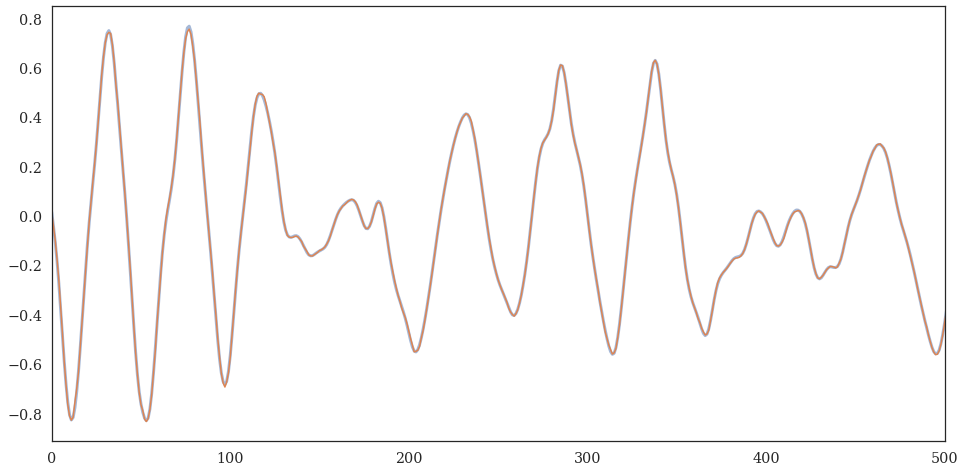

In [114]:
ypred = model(x_val)

plt.figure(figsize = (16, 8))

plt.plot(y_val, linewidth = 3, alpha = 0.5)
plt.plot(ypred.detach().numpy())

plt.xlim([0,500])
plt.show()

In [115]:

def simulate(x0, u, future):
    tw = x0.shape[-1]
    feats = x0.shape[0]

    x_ = x0.reshape((1,feats,tw))
    x = x0
    ypred = model(x_)
    
    for ii in range(1,future):
        new_pair = np.array([u[tw + ii][0], ypred.detach().numpy()[0][0]]).reshape((2,-1))
        x = np.concatenate([x, new_pair], axis = -1)
        
        x_ = x[:, -tw:].reshape((1, feats, tw))
        x_ = torch.from_numpy(x_)
        ypred = model(x_.float())
        
    return x

In [116]:
x0 = x_val[0]
ypred_sim = simulate(x0, utest, 500)
ypred_sim = ypred_sim[-1,train_window:]

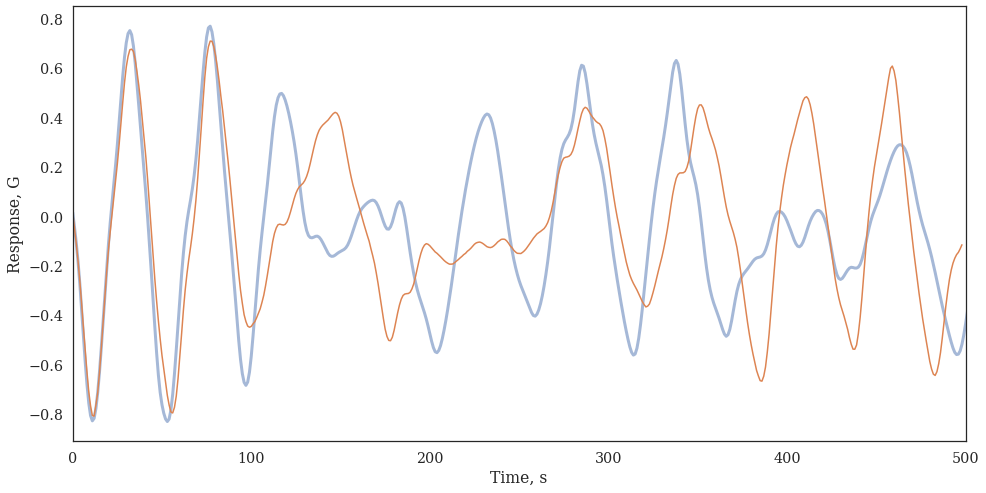

In [117]:

plt.figure(figsize = (16, 8))

plt.plot(y_val, linewidth = 3, alpha = 0.5)
plt.plot(ypred_sim.T)

plt.ylabel('Response, G')
plt.xlabel('Time, s')

plt.xlim([0,500])
plt.show()

In [68]:
utest.shape
u_norm.shape

(10001, 1)

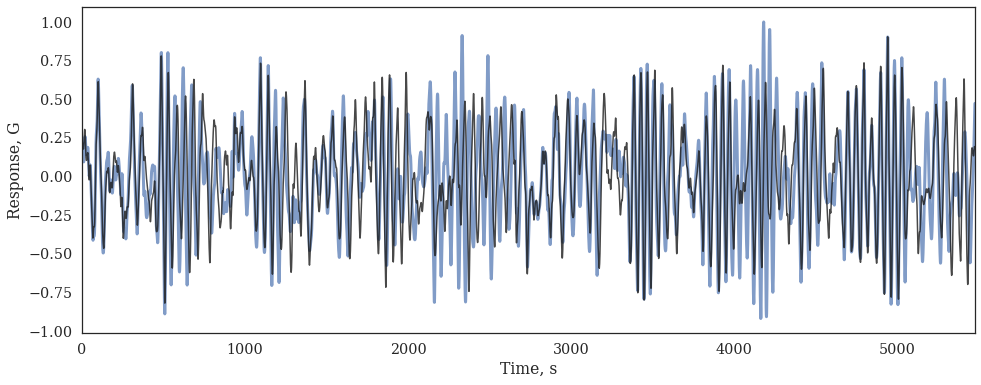

In [118]:
x0 = x_full[0]
npred = x_full.shape[0] - 1
ypred_sim = simulate(x0, ufull, npred)
ypred_sim = ypred_sim[-1,train_window:]

plt.figure(figsize = (16, 6))

plt.plot(yfull[train_window:], linewidth = 3, alpha = 0.7)
plt.plot(ypred_sim.T, 'k', alpha = 0.8)

plt.ylabel('Response, G')
plt.xlabel('Time, s')

plt.xlim([0,npred])
plt.show()

In [89]:
print(ufull.shape)
print(xfull.shape)

(5500, 1)
torch.Size([5450, 2, 24])


In [104]:
nchannels = [3, 6, 9]
nlayers = [3, 5, 7]
kernelsize = [3]

epochs = 500
batch_size = 250

hyperparams = []

for nc in nchannels:
    for nl in nlayers:
        for ks in kernelsize:
            model = TCN(input_size = 2, 
                        output_size = 1, 
                        num_channels = [nc]*nl, 
                        kernel_size = ks, 
                        seq_len = train_window, 
                        dropout = 0.1)
            print([nc]*nl)
            for ep in range(1, epochs+1):
                train(model, ep, x_train, y_train, batch_size)
                if ep % 50 == 0:
                    print('Epoch: {}'.format(ep))
                    tloss = evaluate(model, x_val, y_val)
            
            hyperparams.append([nc, nl, ks, tloss])
            print(hyperparams[-1])
            
pickle.dump(hyperparams, open('hyperparam_runs.pickle', 'wb'))


[3, 3, 3]
Epoch: 50

Test set: Average loss: 1.173970

Epoch: 100

Test set: Average loss: 1.164860

Epoch: 150

Test set: Average loss: 1.174647

Epoch: 200

Test set: Average loss: 1.169710

Epoch: 250

Test set: Average loss: 1.175539

Epoch: 300

Test set: Average loss: 1.177534

Epoch: 350

Test set: Average loss: 1.175668

Epoch: 400

Test set: Average loss: 1.165821

Epoch: 450

Test set: Average loss: 1.174930

Epoch: 500

Test set: Average loss: 1.190137

[3, 3, 3, 1.1901369514374631]
[3, 3, 3, 3, 3]
Epoch: 50

Test set: Average loss: 0.244408

Epoch: 100

Test set: Average loss: 0.248154

Epoch: 150

Test set: Average loss: 0.246772

Epoch: 200

Test set: Average loss: 0.248602

Epoch: 250

Test set: Average loss: 0.248202

Epoch: 300

Test set: Average loss: 0.240986

Epoch: 350

Test set: Average loss: 0.247317

Epoch: 400

Test set: Average loss: 0.244650

Epoch: 450

Test set: Average loss: 0.244559

Epoch: 500

Test set: Average loss: 0.245608

[3, 5, 3, 0.24560780395239

NameError: name 'pickle' is not defined

In [105]:
import pickle 
pickle.dump(hyperparams, open('hyperparam_runs.pickle', 'wb'))

In [106]:
hyperparams

[[3, 3, 3, 1.1901369514374631],
 [3, 5, 3, 0.2456078039523973],
 [3, 7, 3, 0.5105965993993377],
 [6, 3, 3, 0.11973414125472952],
 [6, 5, 3, 0.5458264064765384],
 [6, 7, 3, 0.20835276448076956],
 [9, 3, 3, 0.14021653580262358],
 [9, 5, 3, 0.27441562471524916],
 [9, 7, 3, 0.13629748571598935]]

In [109]:
from statsmodels.tsa.arima_model import ARMA

ModuleNotFoundError: No module named 'statsmodels'